Before viewing the notebook it is recommended to read `README.md`.

# Setting up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cnn.model import *
from cnn.dataset import *
from cnn.constants import *

import os
from IPython.display import Image

import numpy as np
import pandas as pd

import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm.notebook import tqdm

import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder

In [3]:
%matplotlib inline

In [4]:
sns.set_style('white')
_ = torch.manual_seed(RANDOM_SEED)

# Data preparation

First, let's examine the structure of the dataset. Within the `DATA_DIR` folder, there are two directories, each representing a distinct class. The dataset is balanced and quite big. Therefore, stratified sampling can be eschewed in favor of random sampling. Subsequently, the data is partitioned into **train**, **validation** and **test** sets.

In [5]:
dataset = ImageFolder(DATA_DIR)
indices = torch.randperm(len(dataset))

val_size = int(len(dataset) * 0.16)
test_size = int(len(dataset) * 0.2)

train_ds = Subset2Dataset(Subset(dataset, indices[:-(val_size + test_size)]))
val_ds = Subset2Dataset(Subset(dataset, indices[-(val_size + test_size):-val_size]))
test_ds = Subset2Dataset(Subset(dataset, indices[-val_size:]))

Let's take a look at random samples of the data.

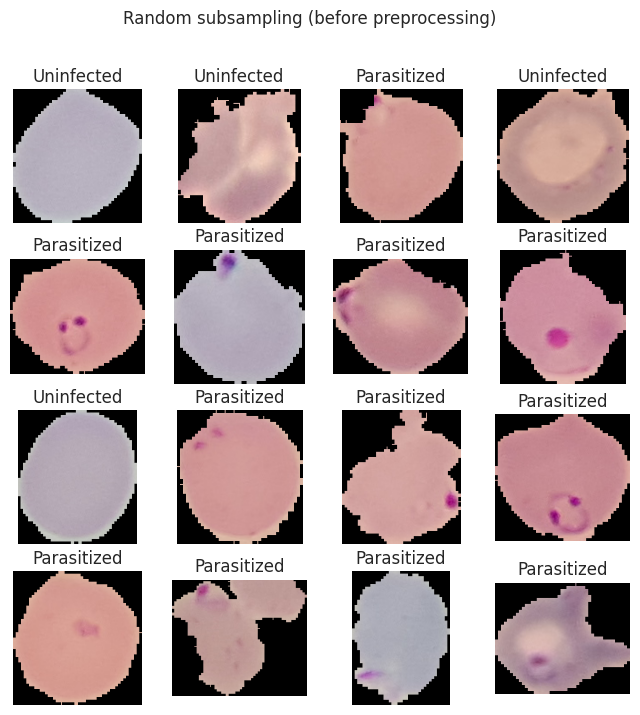

In [6]:
n_rows, n_cols = 4, 4

fig, ax = plt.subplots(n_rows, n_cols, figsize=(8, 8))
fig.suptitle('Random subsampling (before preprocessing)')

idx2class = {idx: cls for cls, idx in dataset.class_to_idx.items()}
sample_indices = torch.randint(len(train_ds), size=(n_rows, n_cols))

for i in range(n_rows):
    for j in range(n_cols):
        sample, target = train_ds[sample_indices[i, j]]
        ax[i, j].set_title(idx2class[target])
        ax[i, j].axis('off')
        ax[i, j].imshow(sample)

Given that the data comprises images rather than tabular data, there are no missing values or traditional features. Instead, only the pixel values of individual images are present, which both simplifies and complicates the task.

Further investigation suggests that some data samples may have incorrect class labels.

In [7]:
SAMPLE_SIZE = (112, 112)  # h, w
image_sizes = np.array([img.size for img, _ in tqdm(train_ds)])

  0%|          | 0/17638 [00:00<?, ?it/s]

More details about the chosen model will be provided later. However, it's essential to note that it is a convolutional neural network (CNN), necessitating a fixed resolution for input images. Nevertheless, the visualization indicates that our samples vary in size. To address this, resizing to the desired input size of our neural network (`SAMPLE_SIZE`) can be implemented.

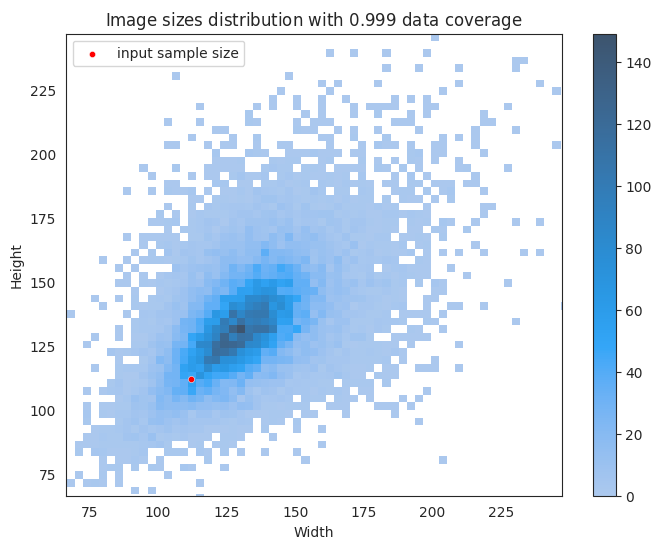

In [8]:
_, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    x=image_sizes[:, 0],
    y=image_sizes[:, 1],
    bins=115,
    ax=ax,
    cbar=True,
)

data_coverage = 0.999
ax.set_xlim(
    xmin=np.quantile(image_sizes[:, 0], (1 - data_coverage) / 2),
    xmax=np.quantile(image_sizes[:, 0], (1 + data_coverage) / 2),
)
ax.set_ylim(
    ymin=np.quantile(image_sizes[:, 1], (1 - data_coverage) / 2),
    ymax=np.quantile(image_sizes[:, 1], (1 + data_coverage) / 2),
)

sns.scatterplot(
    x=[SAMPLE_SIZE[1]],
    y=[SAMPLE_SIZE[0]],
    c='r', s=20,
    label='input sample size',
    legend=True,
    ax=ax,
)

ax.set_title(f'Image sizes distribution with ${data_coverage}$ data coverage')
ax.set_xlabel('Width')
ax.set_ylabel('Height')

_ = ax.legend(loc='upper left')

This way most of the data will be reduced to the desired size.

Furthermore, augmentation is applied, significantly increasing the size of the training dataset:

- Since a cell is considered in a two-dimensional plane, it has no orientation in space, hence a rotated (`RandomRotation`) or mirrored image (`RandomHorizontalFlip`) will have all the same class labeling.
- After rotating the image, a black area may appear around it, which is not typical of the original data. This is addressed using the `crop_black_area` function.

Augmentation can be interpreted as one of the regularization methods. Later, additional approaches will be explored.

Let's examine the same data samples after preprocessing.

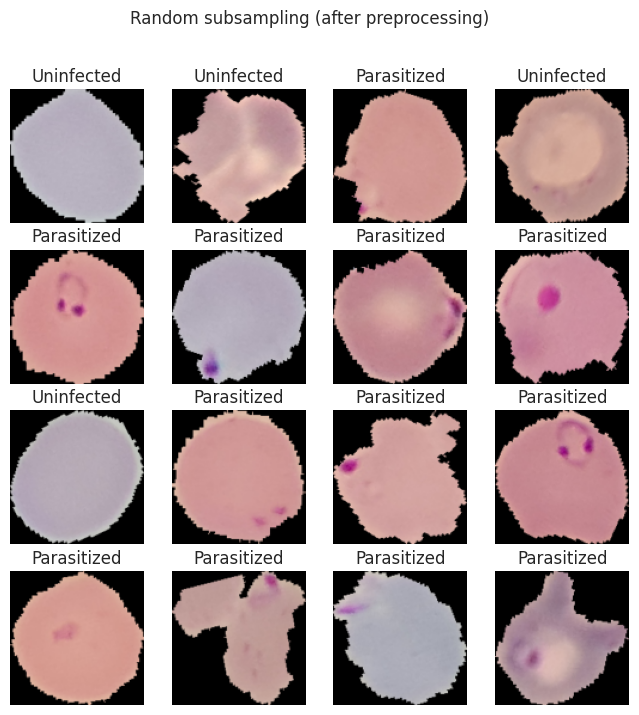

In [9]:
fig, ax = plt.subplots(n_rows, n_cols, figsize=(8, 8))
fig.suptitle('Random subsampling (after preprocessing)')

train_ds.transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(180, expand=True),
    transforms.Lambda(crop_black_area),
    transforms.Resize(SAMPLE_SIZE, antialias=True),
    transforms.ToPILImage(),
])

for i in range(n_rows):
    for j in range(n_cols):
        sample, target = train_ds[sample_indices[i, j]]
        ax[i, j].set_title(idx2class[target])
        ax[i, j].axis('off')
        ax[i, j].imshow(sample)

Neural networks benefit significantly from normalized data; without it, their training may be hindered or even rendered impossible. Standardization involves calculating the mean and standard deviation on the training set.

In [10]:
train_ds.transform = transforms.PILToTensor()

In [11]:
m1, m2 = torch.zeros(2, 3, dtype=torch.float64)
n_nonzero_pixels = sum([torch.any(sample != 0, dim=0).sum() for sample, _ in tqdm(train_ds)])

for sample, _ in tqdm(train_ds):
    pixels = sample[:, torch.any(sample != 0, dim=0)].type(torch.float64)
    m1 += (pixels / n_nonzero_pixels).sum(dim=-1)
    m2 += (pixels ** 2 / n_nonzero_pixels).sum(dim=-1)

biased_var = m2 - m1 ** 2
unbiased_var = biased_var * n_nonzero_pixels / (n_nonzero_pixels - 1)
pixel_std = torch.sqrt(unbiased_var).type(torch.float32)
pixel_mean = m1.type(torch.float32)

  0%|          | 0/17638 [00:00<?, ?it/s]

  0%|          | 0/17638 [00:00<?, ?it/s]

In [12]:
print(f'Channels mean: {pixel_mean}\nChannels std: {pixel_std}')
pixel_mean = pixel_mean[:, None, None]
pixel_std = pixel_std[:, None, None]

Channels mean: tensor([190.1052, 151.6884, 161.1033])
Channels std: tensor([21.0848, 21.0064, 17.5082])


In [13]:
train_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(180, expand=True),
    transforms.Lambda(crop_black_area),
    transforms.Resize(SAMPLE_SIZE, antialias=True),
    transforms.Lambda(MaskedNormalization(pixel_mean, pixel_std)),
])
test_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize(SAMPLE_SIZE, antialias=True),
    transforms.Lambda(MaskedNormalization(pixel_mean, pixel_std)),
])

Instead of the usual normalization, `MaskedNormalization` is utilized. This method excludes the black area surrounding the cell, as it does not pertain to the task and serves solely as empty space filler. Corresponding statistics are computed without considering this area.

In [14]:
train_ds.transform = train_transform
val_ds.transform = test_transform
test_ds.transform = test_transform

# Convolutional neural network

Now, let's proceed to construct a machine learning model. A convolutional neural network is a conventional choice for addressing image classification tasks. The code for the model can be found in `cnn/model.py`, and its architecture will be reviewed shortly.

In [15]:
model = CNN(skip_connections=True).apply(init_weights).to(DEVICE)

Before running full training we need to make sure that the neural network is capable of overfitting on one small data batch.

In [16]:
samples, targets = next(iter(DataLoader(train_ds, batch_size=4)))
samples = samples.to(DEVICE)
targets = targets.unsqueeze(-1).type(torch.float32).to(DEVICE)
samples.shape, targets

(torch.Size([4, 3, 112, 112]),
 tensor([[0.],
         [1.],
         [1.],
         [1.]], device='cuda:0'))

Samples of both classes are present in the chosen batch.

**Binary cross entropy loss function**:$$H(y, \hat{y}) = -\frac{1}{n}\sum_{i=1}^ny_i\log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)$$The chosen loss function is fully suitable for the task at hand. In the code it is implemented through `BCEWithLogitsLoss` class, which performs a trick to ensure numerical stability. To make this possible, during training the model should return not the estimated probabilities of the individual classes, but their so-called **logits**.

In [17]:
optimizer = optim.Adam(model.parameters(), 2e-3)
criterion = nn.BCEWithLogitsLoss()

losses = []

for _ in range(3):
    model.zero_grad()
    
    logits = model(samples)
    loss = criterion(logits, targets)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

/home/tejpaper/.local/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


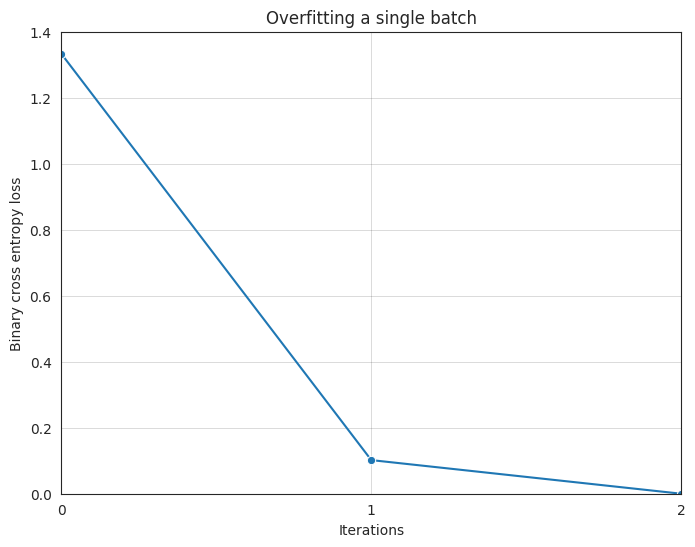

In [18]:
_, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(losses, marker='o', ax=ax)

# title and labels
ax.set_title('Overfitting a single batch')
ax.set_ylabel('Binary cross entropy loss')
ax.set_xlabel('Iterations')

# x axis
ax.grid(axis='x', color='black', alpha=.2, linewidth=.5)
locator = ticker.FixedLocator(range(len(losses)))
ax.xaxis.set_major_locator(locator)
ax.set_xlim((0, len(losses) - 1))

# y axis
ax.grid(axis='y', color='black', alpha=.2, linewidth=.5)
_ = ax.set_ylim(ymin=0)

The learning curve suggests that achieving zero loss is feasible, prompting us to commence the hyperparameter optimization process.

# Hyperparameters optimization

To facilitate access to the preprocessed data for `train.py`, a file is created containing an interface.

In order for the `train.py` file to have access to what we've done so far, a file containing an interface to allow access to the preprocessed data was created.

In [19]:
torch.save(dict(
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
), DATA_INTERFACE_PATH)


Upon executing `train.py`, logs of the individual hyperparameter configurations will be created. The corresponding files are attached and ready to use, as the process itself can be time-consuming. Additionally, the folders contain the respective learning curves.

Unfortunately the implementation of convolution in **PyTorch** does not support deterministic solutions. This can be enabled at the cost of training time. Anything beyond that is determined by `RANDOM_SEED` and will be deterministic in each run for different hyperparameters.

The hyperparameter search itself is based on [Bayesian optimization](https://arxiv.org/abs/1807.02811).

The chosen metric is **accuracy**, as it is the simplest option for a balanced dataset. It should be noted that it also makes sense to consider other classification metrics, which will balance the errors of the first and second types in the right way. This step is skipped for the sake of simplicity.

[Stochastic Weight Averaging](https://pytorch.org/blog/pytorch-1.6-now-includes-stochastic-weight-averaging/) is also used; it approximates an ensemble of multiple models and has a better ability in generalization.

Feel free to uncomment the following cell if you wish.

In [20]:
# %run train.py

Let's combine all the logs into one pandas dataframe.

In [21]:
config_dirs = sorted(list(os.walk(LOGS_DIR))[1:], key=lambda x: int(x[0][-3:]))
training_results = []

for i, (config_dir, *_) in enumerate(config_dirs):
    config_logs = pd.read_csv(os.path.join(config_dir, 'epochs.csv')).iloc[:1]
    config_logs = config_logs.drop(columns=['epoch', 'train_acc', 'val_acc'])
    config_logs.insert(0, 'config_id', i)
    training_results.append(config_logs)
    
training_results = pd.concat(training_results).set_index('config_id')
training_results.swa_val_acc = training_results.swa_val_acc.apply(lambda x: max(x, 1 - x))
training_results = training_results.sort_values(by='swa_val_acc', ascending=False) 
training_results.head()

dropout  skip_connections        lr    swa_lr  batch_size  \
config_id                                                               
12         0.164804             False  0.010000  0.000798          64   
2          0.176118             False  0.001398  0.008081          64   
18         0.548456             False  0.006313  0.000100          64   
21         0.584180             False  0.008073  0.000100         128   
4          0.395962             False  0.003545  0.020311          32   

           swa_val_acc  
config_id               
12            0.961713  
2             0.960080  
18            0.959535  
21            0.958628  
4             0.958265

Now, the visualization can be done using a parallel coordinates plot.

In [22]:
fig = go.Figure(go.Parcoords(
    line=dict(color=training_results.swa_val_acc,
              colorscale='RdYlGn',
              showscale=True,
              cmin=0.5,
              cmax=1),
    dimensions=[
        dict(label='Dropout',
             range=[0.1, 0.9],
             values=training_results.dropout),
        dict(label='Skip Connections',
             range=[-0.2, 1.2],
             tickvals=[0, 1],
             ticktext=['False', 'True'],
             values=training_results.skip_connections.astype(int)),
        dict(label='Learning Rate',
             range=[5e-6, 0.01],
             values=training_results.lr),
        dict(label='SWA Learning Rate',
             range=[1e-4, 0.05],
             values=training_results.swa_lr),
        dict(label='Batch Size',
             range=[8, 128],
             tickvals=[8, 16, 32, 64, 128],
             values=training_results.batch_size),
        dict(label='Accuracy',
             range=[0.5, 1],
             values=training_results.swa_val_acc),
    ]))
fig.update_layout(
    title='Parallel coordinates of CNN training process',
    autosize=False,
    width=1000,
    height=600,
)
fig.show()

Let's take a look at the hyperparameters we optimized:

- **dropout** is another regularization technique, in the network it is located in fully connected layers,
- **skip connections** is a technique to provide better gradient flow through the network. Most of the time it helps only for deep nets, here it is added for fun,
- **learning rate** and **SWA learning rate** adjust the step size in gradient descent,
- **batch size** starts to play a greater role when batch normalization layers (another regularization technique) appear in the network. This is the case.

Most models are above the $0.9$ level on accuracy. Establishing exact patterns between hyperparameters and performance is quite difficult since the network is robust to their choice.

Further, the optimal configuration of hyperparameters is demonstrated.

In [23]:
best_config = training_results.iloc[0]
best_config

dropout             0.164804
skip_connections       False
lr                      0.01
swa_lr              0.000798
batch_size                64
swa_val_acc         0.961713
Name: 12, dtype: object

# Final model

## Training

In [24]:
from train import train, learning_curve

In [25]:
_ = torch.manual_seed(RANDOM_SEED)

To visualize the gradient behavior throughout the learning process in different layers of the network, a specific batch is selected for recording the corresponding measurements.

In [26]:
samples, targets = next(iter(DataLoader(train_ds, batch_size=256)))
samples = samples.to(DEVICE)
targets = targets.unsqueeze(-1).type(torch.float32).to(DEVICE)

`max_epochs` affects the quality of the model. Further it will be proved that the number below is **not** an optimal choice.

In [27]:
max_epochs = 26

In [28]:
model = CNN(best_config.dropout, best_config.skip_connections).apply(init_weights).to(DEVICE)
training_loop = train(model, train_ds, val_ds, best_config.lr, best_config.swa_lr, int(best_config.batch_size), max_epochs)

In [29]:
criterion = nn.BCELoss()

Next, variables are created to accumulate the statistics of interest. Unfortunately, visualizing gradients for all parameters of all layers is not feasible due to their large number. Therefore, only the most important layers have been selected for visualization.

It is worth mentioning that batch normalization layers also have their own trained parameters that implement affine transformation after normalization.

In [30]:
train_scores = []
val_scores = []
tracked_grad_layers = [
    'input_conv.0.weight',
    'conv.0.0.weight',
    'conv.0.3.weight',
    'intermediate_conv.0.0.weight',
    'conv.1.0.weight',
    'conv.1.3.weight',
    'intermediate_conv.1.0.weight',
    'conv.2.0.weight',
    'conv.2.3.weight',
    'intermediate_conv.2.0.weight',
    'conv.3.0.weight',
    'conv.3.3.weight',
    'intermediate_conv.3.0.weight',
    'fc.1.weight',
    'fc.4.weight',
    'fc.7.weight',
]
gradients = {layer: [] for layer in tracked_grad_layers}

In [31]:
for epoch in range(max_epochs):
    train_acc, val_acc = next(training_loop)
    train_scores.append(train_acc)
    val_scores.append(val_acc)
    
    probs = model(samples)
    loss = criterion(probs, targets)
    loss.backward()
    
    for name, params in model.named_parameters():
        gradients.get(name, []).append(torch.flatten(params.grad.cpu()))

Epochs:   0%|          | 0/26 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Next, there's no need to construct a backward computational graph, so the corresponding attribute of the model parameters is deactivated. Result is saved to a separate file.

In [32]:
swa_model, swa_val_acc = next(training_loop)
for params in swa_model.parameters():
    params.requires_grad = False
torch.save(swa_model.state_dict(), 'model.pt')

## Model visualization

First, let's see how PyTorch can present a model in text form.

In [33]:
swa_model

AveragedModel(
  (module): CNN(
    (input_conv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (intermediate_conv): ModuleList(
      (0): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
    

In [34]:
print(f'Total number of parameters: {sum(params.numel() for params in swa_model.parameters())}')

Total number of parameters: 2429289


This can be useful for revealing some details, but also does not preserve the correct order of the individual layers in our case. Now let's look at the method implemented using [this](https://github.com/HarisIqbal88/PlotNeuralNet) repository.

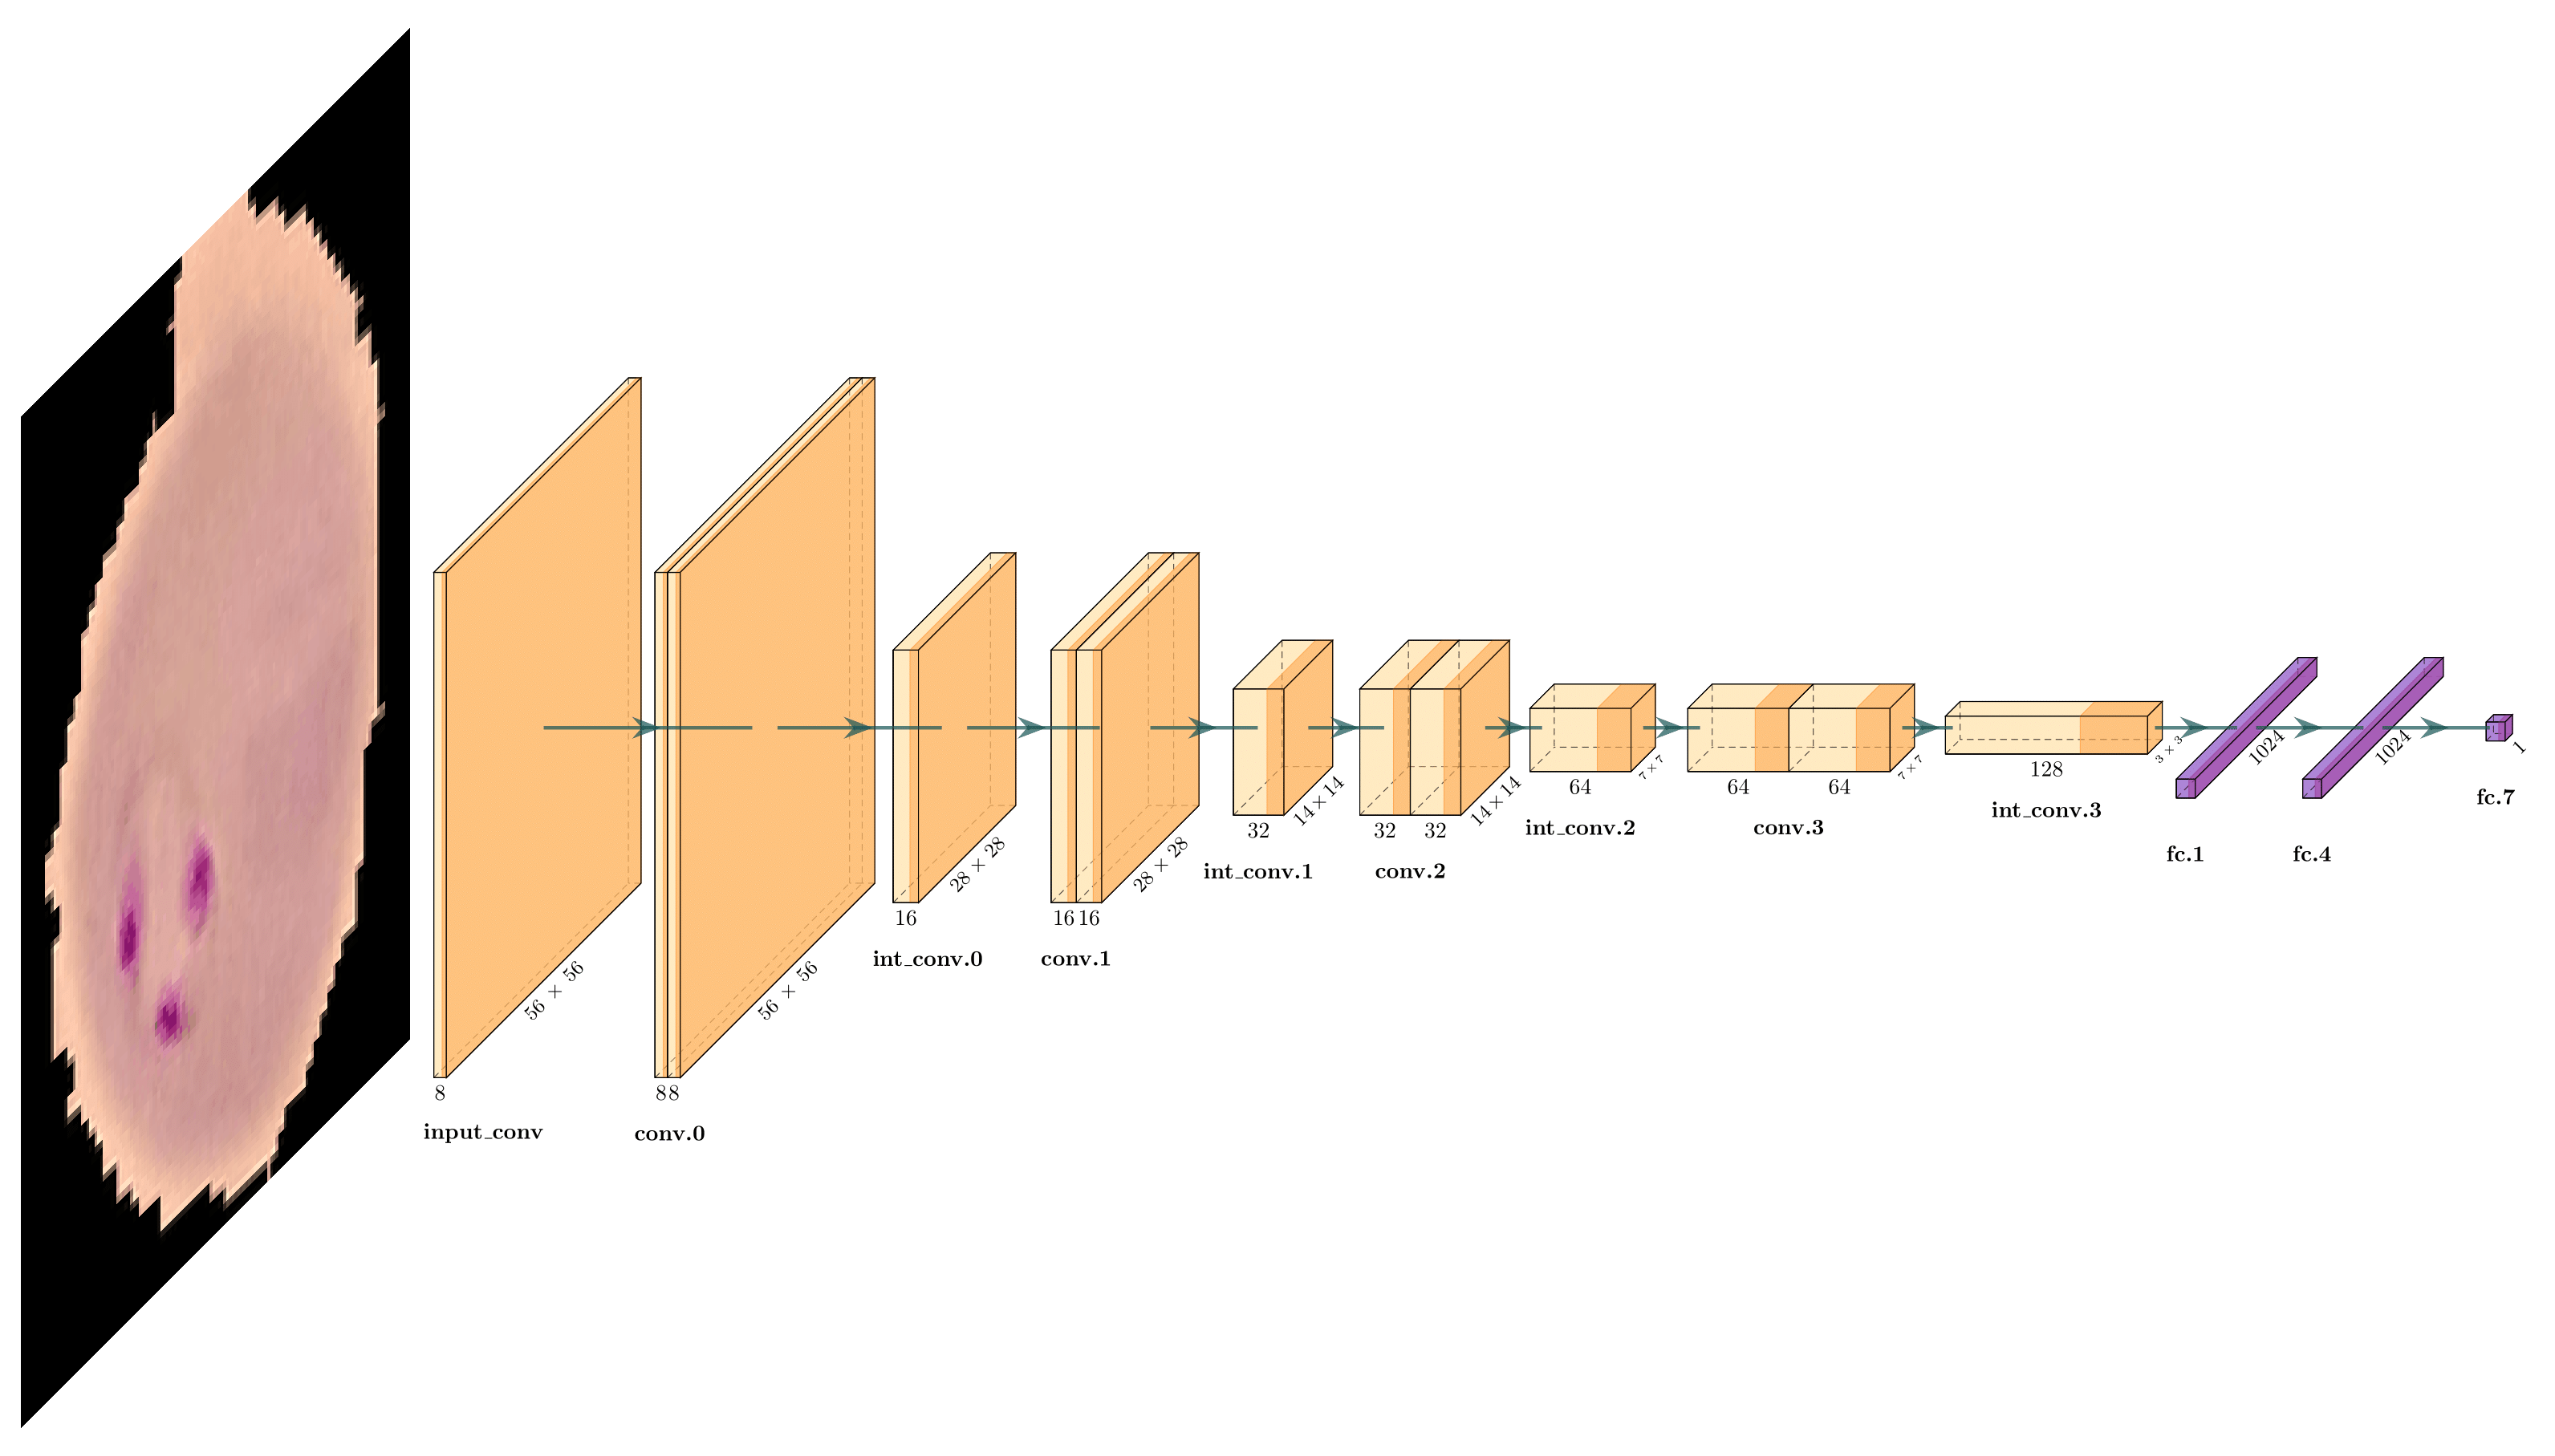

In [35]:
Image(filename=os.path.join('extra', 'architecture.png'))


That's a completely different matter! The corresponding PDF file has been provided in the extra directory for better quality.

## Training process visualization

In [36]:
grad_stats = pd.DataFrame(
    {layer: [g_i.abs().mean().log().item() for g_i in grads]
     for layer, grads in gradients.items()}
).reindex(tracked_grad_layers, axis=1)
grad_stats.index += 1

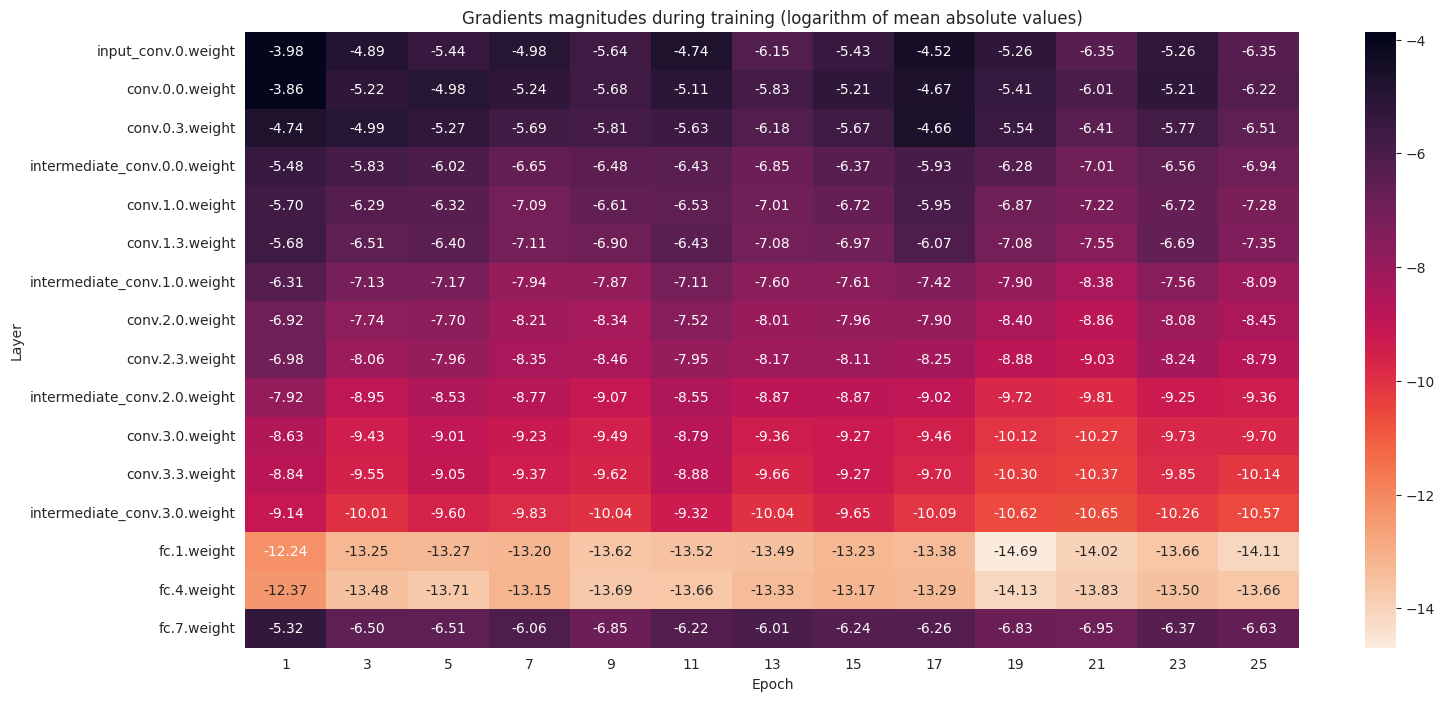

In [37]:
_, ax = plt.subplots(figsize=(17, 8))
sns.heatmap(
    data=grad_stats[::2].T,
    fmt='.02f',
    cmap=sns.cm.rocket_r,
    annot=True,
    ax=ax,
)

# title and labels
ax.set_title('Gradients magnitudes during training (logarithm of mean absolute values)')
ax.set_ylabel('Layer')
_ = ax.set_xlabel('Epoch')

Every second epoch is visualized here to ensure the image fits on the screen.

It's notable that gradients vary across different layers, indicating that some parameters are more prone to change than others. This is expected behavior.

Also, over time, the gradients become closer to zero, because the loss function has a flatter surface in the neighborhood of the local minimum.

An individual histogram can also be drawn for each cell of this table.

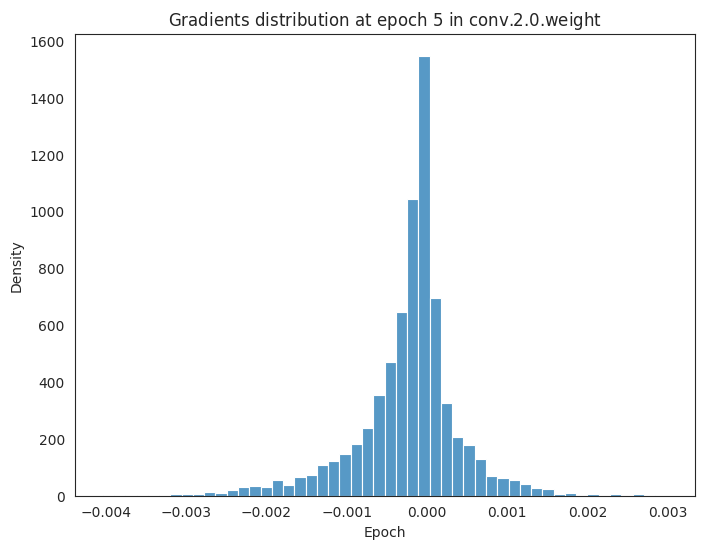

In [38]:
layer = 'conv.2.0.weight'
epoch = 5

_, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    data=gradients[layer][epoch - 1],
    bins=50,
    stat='density', 
    ax=ax,
)

# title and labels
ax.set_title(f'Gradients distribution at epoch ${epoch}$ in {layer}')
_ = ax.set_xlabel('Epoch')

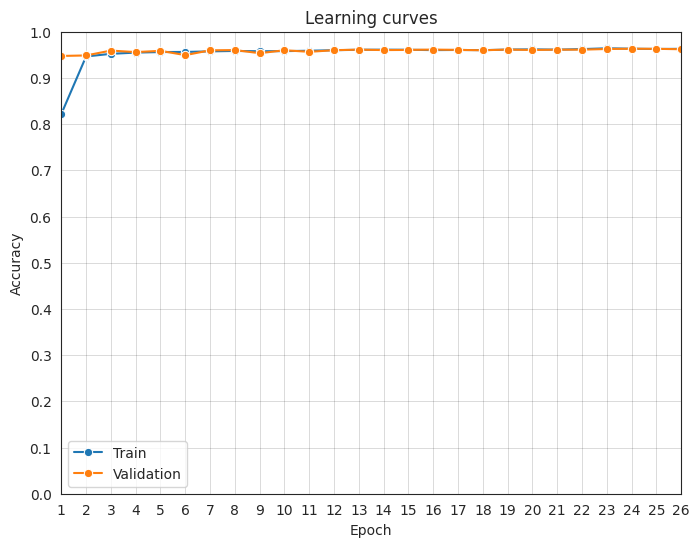

In [39]:
_ = learning_curve(pd.DataFrame({
    'epoch': range(1, max_epochs + 1),
    'train_acc': train_scores,
    'val_acc': val_scores,
}), max_epochs)

The learning curve indicates the large convergence rate of the neural network. However, this does not mean that longer training cannot help to improve the quality.

Next, consider the differences in model behavior on the train, validation, and test sets.

In [41]:
train_ds.transform = test_transform

In [42]:
swa_train_acc = 0
train_losses = []

for sample, target in tqdm(train_ds):
    sample = sample.to(DEVICE).unsqueeze(0)
    target = torch.tensor([[target]], dtype=torch.float32, device=DEVICE)

    prob = swa_model(sample)
    
    train_losses.append(criterion(prob, target).cpu())
    swa_train_acc += (prob > 0.5) == target
    
swa_train_acc = swa_train_acc.item() / len(train_ds)

  0%|          | 0/17638 [00:00<?, ?it/s]

In [43]:
val_losses = []

for sample, target in tqdm(val_ds):
    sample = sample.to(DEVICE).unsqueeze(0)
    target = torch.tensor([[target]], dtype=torch.float32, device=DEVICE)
    val_losses.append(criterion(swa_model(sample), target).cpu())

  0%|          | 0/5511 [00:00<?, ?it/s]

In [44]:
swa_test_acc = 0
test_losses = []
test_true = []
test_pred = []

for sample, target in tqdm(test_ds):
    sample = sample.to(DEVICE).unsqueeze(0)
    test_true.append(target)
    target = torch.tensor([[target]], dtype=torch.float32, device=DEVICE)
    
    prob = swa_model(sample)
    pred = prob > 0.5
    test_pred.append(pred.cpu())

    test_losses.append(criterion(prob, target).cpu())
    swa_test_acc += pred == target

swa_test_acc = swa_test_acc.item() / len(test_ds)

  0%|          | 0/4409 [00:00<?, ?it/s]

In [45]:
print(
    f'Train accuracy: {swa_train_acc:.04f},',
    f'Validation accuracy: {swa_val_acc:.04f},',
    f'Test accuracy: {swa_test_acc:.04f}.',
sep='\n')

Train accuracy: 0.9638,
Validation accuracy: 0.9624,
Test accuracy: 0.9651.


The test dataset has the best result. Let's make sure in another way that the model is not overfitting.

In [46]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
test_losses = np.array(test_losses)

In [47]:
losses = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_losses': test_losses,
}
max_size = max([v.size for v in losses.values()])
losses_pad = {k: np.pad(v, pad_width=(0, max_size - v.size,), mode='constant', constant_values=np.nan) 
              for k, v in losses.items()}
losses = pd.DataFrame(losses_pad)

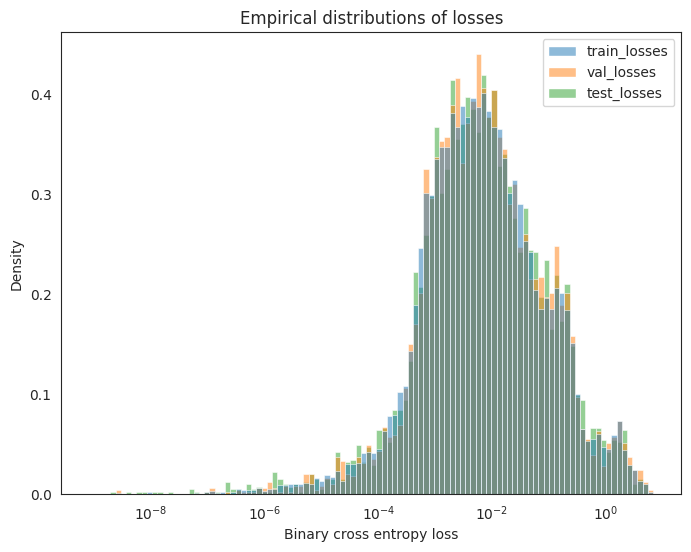

In [48]:
_, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    data=losses, 
    log_scale=True, 
    stat='density', 
    common_norm=False,
    ax=ax,
)

# title and labels
ax.set_title('Empirical distributions of losses')
_ = ax.set_xlabel('Binary cross entropy loss')

The presented histogram shows that the losses of all three sets are generated from the same distribution. This means that we are in the golden mean between overfitting and underfitting. The best result can be achieved with a slight overfitting by increasing `max_epochs`. If additional time is available, I would also replace `Adam` with `SGD`, which would probably give better generalizability of the model by increasing the training time.

## Results

In [49]:
test_true = np.array(test_true).flatten()
test_pred = np.array(test_pred).flatten()

In [50]:
from sklearn.metrics import confusion_matrix

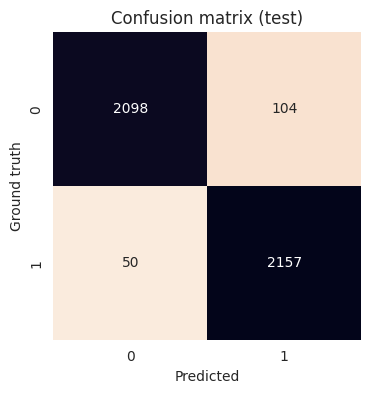

In [51]:
_, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    data=confusion_matrix(test_true, test_pred),
    fmt='g',
    cmap=sns.cm.rocket_r,
    square=True,
    annot=True, 
    cbar=False,
    ax=ax,
)

# title and labels
ax.set_title('Confusion matrix (test)')
ax.set_ylabel('Ground truth')
_ = ax.set_xlabel('Predicted')

In [52]:
idx2class

{0: 'Parasitized', 1: 'Uninfected'}

Confusion matrix also shows good results.

Now let's take a look at the top best and worst predictions that we will compile based on the loss function values.

In [55]:
n_samples = 4
test_ds.transform = None

In [56]:
sorted_pred_i = np.argsort(test_losses)
best_predictions_i = sorted_pred_i[:n_samples]
worst_predictions_i = sorted_pred_i[-n_samples:]

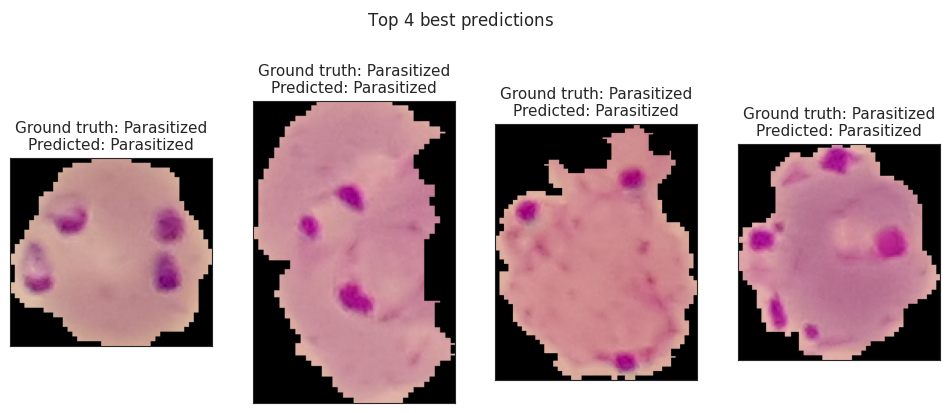

In [59]:
fig, ax = plt.subplots(1, n_samples, figsize=(12, 5))
fig.suptitle(f'Top ${n_samples}$ best predictions')

for i in range(n_samples):
    sample_idx = best_predictions_i[i]
    sample, target = test_ds[sample_idx]
    ax[i].set_title(f'Ground truth: {idx2class[target]}\nPredicted: {idx2class[test_pred[sample_idx]]}', fontsize=11)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(sample)

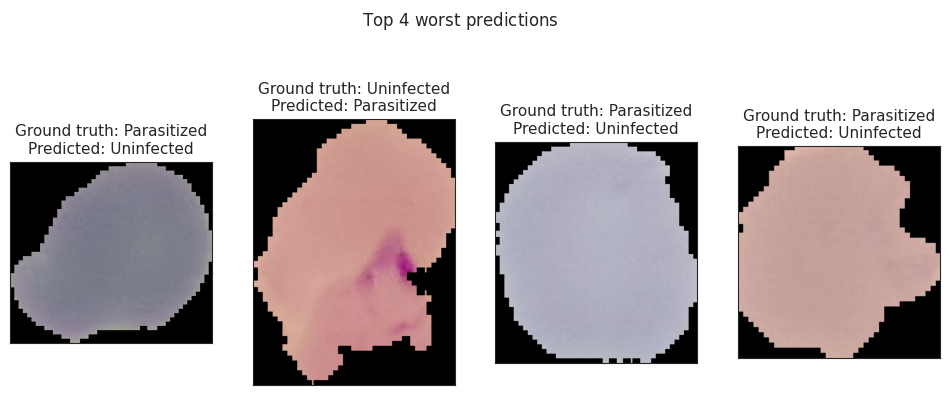

In [62]:
fig, ax = plt.subplots(1, n_samples, figsize=(12, 5))
fig.suptitle(f'Top ${n_samples}$ worst predictions')

for i in range(n_samples):
    sample_idx = worst_predictions_i[i]
    sample, target = test_ds[sample_idx]
    ax[i].set_title(f'Ground truth: {idx2class[target]}\nPredicted: {idx2class[test_pred[sample_idx]]}', fontsize=11)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(sample)

As you can see, the worst predictions look suspicious. This is not a bug in the code. As mentioned earlier, the dataset contains samples with potentially incorrect class labels, which are likely causing difficulties for the neural network.

Visualization of decision boundaries cannot be done directly due to the number of features, but [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) or representation of features in a latent embedded 2D space can help, which the network does not manage to produce, since no layer has two metafeatures at the output.